# Homework 6

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Matheus Raka Pradnyatama
* matheusraka@uchicago.edu

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import jinja2

from scipy.stats import norm
from functools import partial
from typing import Union, List
from sklearn.linear_model import LinearRegression

pd.options.display.float_format = "{:,.4f}".format

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
path1 = '/Users/matheus/Desktop/finm-portfolio-2024/data/momentum_data.xlsx'
ff_factors = pd.read_excel(path1, sheet_name = 'factors (excess returns)').set_index('Date')
momentum = pd.read_excel(path1, sheet_name = 'momentum (excess returns)').set_index('Date')
mom_deciles = pd.read_excel(path1, sheet_name = 'deciles (total returns)').set_index('Date')
tercile_port = pd.read_excel(path1, sheet_name = 'size_sorts (total returns)').set_index('Date')
rf = pd.read_excel(path1, sheet_name = 'risk-free rate').set_index('Date')

ff_factors['UMD'] = momentum['UMD']

In [4]:
def calc_return_metrics(data, as_df=False, adj=12):
    """
    Calculate return metrics for a DataFrame of assets.

    Args:
        data (pd.DataFrame): DataFrame of asset returns.
        as_df (bool, optional): Return a DF or a dict. Defaults to False (return a dict).
        adj (int, optional): Annualization. Defaults to 12.

    Returns:
        Union[dict, DataFrame]: Dict or DataFrame of return metrics.
    """
    summary = dict()
    summary["Annualized Return"] = data.mean() * adj
    summary["Annualized Volatility"] = data.std() * np.sqrt(adj)
    summary["Annualized Sharpe Ratio"] = (
        summary["Annualized Return"] / summary["Annualized Volatility"]
    )
    summary["Annualized Sortino Ratio"] = summary["Annualized Return"] / (
        data[data < 0].std() * np.sqrt(adj)
    )
    return pd.DataFrame(summary, index=data.columns) if as_df else summary


def calc_risk_metrics(data, as_df=False, var=0.05):
    """
    Calculate risk metrics for a DataFrame of assets.

    Args:
        data (pd.DataFrame): DataFrame of asset returns.
        as_df (bool, optional): Return a DF or a dict. Defaults to False.
        adj (int, optional): Annualizatin. Defaults to 12.
        var (float, optional): VaR level. Defaults to 0.05.

    Returns:
        Union[dict, DataFrame]: Dict or DataFrame of risk metrics.
    """
    summary = dict()
    summary["Skewness"] = data.skew()
    summary["Excess Kurtosis"] = data.kurtosis()
    summary[f"VaR ({var})"] = data.quantile(var, axis=0)
    summary[f"CVaR ({var})"] = data[data <= data.quantile(var, axis=0)].mean()
    summary["Min"] = data.min()
    summary["Max"] = data.max()

    wealth_index = 1000 * (1 + data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks

    summary["Max Drawdown"] = drawdowns.min()

    summary["Bottom"] = drawdowns.idxmin()
    summary["Peak"] = previous_peaks.idxmax()

    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][: drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin() :]]).T
        recovery_date.append(
            recovery_wealth[recovery_wealth[col] >= prev_max].index.min()
        )
    summary["Recovery"] = ["-" if pd.isnull(i) else i for i in recovery_date]

    summary["Duration (days)"] = [
        (i - j).days if i != "-" else "-"
        for i, j in zip(summary["Recovery"], summary["Bottom"])
    ]

    return pd.DataFrame(summary, index=data.columns) if as_df else summary


def calc_performance_metrics(data, adj=12, var=0.05):
    """
    Aggregating function for calculating performance metrics. Returns both
    risk and performance metrics.

    Args:
        data (pd.DataFrame): DataFrame of asset returns.
        adj (int, optional): Annualization. Defaults to 12.
        var (float, optional): VaR level. Defaults to 0.05.

    Returns:
        DataFrame: DataFrame of performance metrics.
    """
    summary = {
        **calc_return_metrics(data=data, adj=adj),
        **calc_risk_metrics(data=data, var=var),
    }
    summary["Calmar Ratio"] = summary["Annualized Return"] / abs(
        summary["Max Drawdown"]
    )
    return pd.DataFrame(summary, index=data.columns)

### 2.1 Is Momentum sill profitable?

The excess returns of lucrative trading strategies often disappear once the strategy is well-known. The first widely-cited paper on momentum was published in 1993. Have momentum returns or risk changed since then? The AQR case takes place at the end of 2008. Have momentum returns changed in 2009-2024?

Investigate by filling out the summary statistics below for the full-sample and three sub-samples.

#### (a) Using the data provided, fill in Table 1 with the appropriate stats for $\tilde{r}^{\text {mom:FF }}$.

$$
\begin{equation*}
\begin{aligned}
&\text { Table 2: Long-only momentum performance. }\\
&\begin{array}{llllll}
\hline \hline \text { Subsample } \quad \text { mean } \quad \text { vol } & \text { Sharpe } & \text { skewness } & \text { corr. to } \tilde{r}^m & \text { corr. to } \tilde{r}^v \\
\hline \hline & & & & \\
1927-2024 & & & \\
1927-1993 & & & \\
1994-2008 & & & \\
2009-2024 & & & \\
\hline \hline
\end{array}
\end{aligned}
\end{equation*}
$$

In [5]:
periods = [['1927', '2024'], ['1927', '1993'], ['1994', '2008'], ['2009', '2024']]
summary_col_names = ['Annualized Return','Annualized Volatility','Annualized Sharpe Ratio','Skewness']
res = []
for period in periods:
    temp = momentum.loc[period[0]:period[1]]
    temp_ff = ff_factors.loc[period[0]:period[1]]
    summary = calc_performance_metrics(temp)[summary_col_names]
    summary['mkt_corr'] = temp_ff.corr().loc['MKT',['UMD']] # correlation to market premium
    summary['val_corr'] = temp_ff.corr().loc['HML',['UMD']] # correlation to value premium
    summary = summary.T.iloc[:,0].rename(f'{period[0]} - {period[1]}')
    res.append(summary)
summary  = pd.concat(res, axis=1).T
summary

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Skewness,mkt_corr,val_corr
1927 - 2024,0.0753,0.1625,0.4635,-2.9905,-0.3443,-0.4064
1927 - 1993,0.0901,0.1600,0.5630,-3.8082,-0.3625,-0.4950
1994 - 2008,0.1044,0.1756,0.5945,-0.5820,-0.2345,-0.1294
2009 - 2024,-0.0151,0.1585,-0.0952,-2.6910,-0.3676,-0.3209


#### (b) Has momentum changed much over time, as seen through these subsample statistics?

It doesn't change much in most of the periods. But the momentum is showing negative return after 2009.

#### (c) Does this data support AQR's argument that momentum is an important piece of the ideal portfolio? What if mean returns to momentum are in actuality near zero due to transaction costs - would there still be evidence here that momentum is valuable?

Yes, It was definitely profitable at 2008 when AQR was considering to launch the momentum product. Also, the momentum has a low correlation with market and value factor, which makes it a good diversifier. Even if the mean return is near zero, the momentum is still valuable because of its low correlation with other factors. Notably, even though the return profile has changed, it has maintained lower correlations to the market and value factors.

Having momentum in your portfolio, even if the mean is 0, can reduce your overall portfolio risk due to a diversification effect.

### 2.2. Whether a long-only implementation of momentum is valuable.

Construct your own long-only implementation:

$$\tilde{r}^{momU:FF} = \frac{1}{2} (\tilde{r}^{momBU} + \tilde{r}^{momSU}) − r^f $$

Note that this is following the FF approach of treating big and small stocks separately. This would be very similar to a scaled version of,

$$\tilde{r}^{momU} = \frac{1}{3} (\tilde{r}^{mom(8)} + \tilde{r}^{mom(9)} + \tilde{r}^{mom(10)}) − r^f $$


For the question below, use the FF-style $\tilde{r}^{momU:FF}_t$


#### (a) Fill out Table 2 for the data in the period 1994-2024.

$$
\begin{equation*}
\begin{aligned}
&\text { Table 2: Long-only momentum performance. }\\
&\begin{array}{llllll}
\hline \hline \text { 1994-2024 } & \text { mean } \quad \text { vol } & \text { Sharpe } & \text { skew } & \text { corr. to } \tilde{r}^m & \text { corr. to } \tilde{r}^v \\
\hline \hline \text { Long-and-short, }\left(\tilde{r}^{\text {mom:FF }}\right) & & & \\
\text { Long-only }\left(\tilde{r}^{\text {momU:FF }}\right) & & & \\
\hline \hline
\end{array}
\end{aligned}
\end{equation*}
$$

In [6]:
mom_long = (tercile_port['BIG HiPRIOR'] + tercile_port['SMALL HiPRIOR'])/2 - rf['RF'] # long-only strategy
mom_names = ['long_and_short','long_only']

temp = ff_factors.copy().rename(columns={'UMD':'long_and_short'}) # FF UMD is a long/short strategy
temp['long_only']  = mom_long
summary = calc_performance_metrics(temp.loc["1994":, mom_names])[summary_col_names]
summary['mkt_corr'] = temp.corr().loc['MKT', mom_names]
summary['val_corr'] = temp.corr().loc['HML', mom_names]
summary

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Skewness,mkt_corr,val_corr
long_and_short,0.0432,0.1677,0.2575,-1.4460,-0.3443,-0.4064
long_only,0.1172,0.1784,0.6569,-0.4448,0.9358,0.2105


#### (b)  Is long-only momentum as attractive as long-short momentum with respect to mean, volatility, and Sharpe Ratio?

Yes, long-only looks even more attractive than long-short momentum. The mean return is higher, while the volatility is similar. Sharpe ratio is higher as well.

#### (c) Is long-only momentum as diversifying as long-short momentum with respect to market and value premia?

No, the long-only momentum portfolio has 93.6% of correlation with market, whereas the long-short momentum portfolio has -34% of correlation with market. This is because the long-only momentum portfolio is still exposed to market risk. Therefore, it does not diversify at all.

#### (d) Show a plot of the cumulative product of $1+\tilde{r}^{\text {mom:FF }}$ and $1+\tilde{r}^{\text {momU:FF }}$ over the 1994-2024 subsample. $^2$

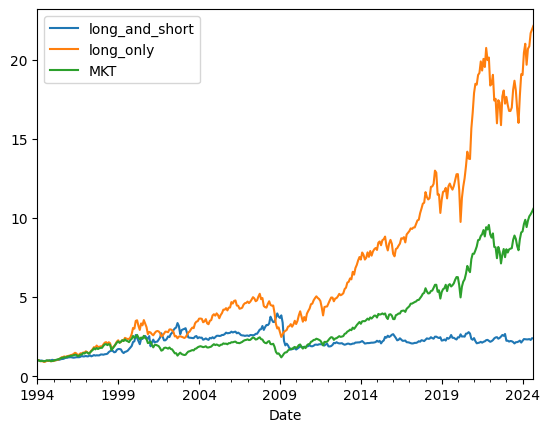

In [7]:
(1 + temp[mom_names + ['MKT']].loc['1994':]).cumprod().plot(); # from 1994 until present

### 2.3. Is momentum just data mining, or is it a robust strategy?

Assess how sensitive the threshold for the “winners” and “losers” is in the results. Specifically, we compare three constructions:

- long the top 1 decile and short the bottom 1 deciles:

$$ \tilde{r}^{momD1} = r^{mom(10)} - r^{mom(1)}$$

- long the top 3 deciles and short the bottom 3 deciles:


$$ 
\begin{aligned}
\tilde{r}^{momD3} &= \frac{1}{3}(r^{mom(8)} + r^{mom(9)} + r^{mom(10)}) - \frac{1}{3} (r^{mom(3)} + r^{mom(2)} + r^{mom(1)})\\
&= \frac{1}{3}\sum_{k = 8}^{10} r^{mom(k)} - \frac{1}{3}\sum_{k = 1}^{3} r^{mom(k)} 
\end{aligned}$$


- long the top 5 deciles and short the bottom 5 decile:

$$ \tilde{r}^{momD5} = \frac{1}{5}\sum_{k = 6}^{10} r^{mom(k)} - \frac{1}{5}\sum_{k = 1}^{5} r^{mom(k)} $$

#### (a) Compare all three constructions, (in the full-sample period,) by filling out the stats in the table below for the period 1994-2024.

$$
\begin{equation}
\begin{aligned}
&\text { Table 3: Robustness of momentum construction. }\\
&\begin{array}{lllllll}
\hline \hline \text { 1994-2024 } \quad \text { mean } & \text { vol } & \text { Sharpe } & \text { skewness } & \text { corr. to } \tilde{r}^m & \text { corr. to } \tilde{r}^v \\
\hline \hline \tilde{r}^{\text {momD1 }} & & & & & \\
\tilde{r}^{\text {momD3 }} & & & & \\
\tilde{r}^{\text {momD5 }} & & & & \\
\hline \hline
\end{array}
\end{aligned}
\end{equation}
$$

In [8]:
ls_1decile = mom_deciles['Hi PRIOR'] - mom_deciles['Lo PRIOR'] # mom(10) - mom(1)
ls_3decile = mom_deciles.iloc[:,-3:].mean(axis = 1) - mom_deciles.iloc[:,:3].mean(axis = 1) # last 3 columns - first 3 columns
ls_5decile = mom_deciles.iloc[:,-5:].mean(axis = 1) - mom_deciles.iloc[:,:5].mean(axis = 1) # last 5 columns - first 5 columns

ls_names = ['mom_D1','mom_D3','mom_D5']
temp = ff_factors.copy()
temp[ls_names] = pd.concat([ls_1decile, ls_3decile, ls_5decile], axis=1)
summary = calc_performance_metrics(temp.loc["1994":, ls_names + ['UMD']])[summary_col_names] # from 1994 to present
summary['mkt_corr'] = temp.corr().loc['MKT', ls_names + ['UMD']]
summary['val_corr'] = temp.corr().loc['HML', ls_names + ['UMD']]
summary

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Skewness,mkt_corr,val_corr
mom_D1,0.0820,0.2990,0.2742,-1.3046,-0.3690,-0.4044
mom_D3,0.0286,0.1934,0.1476,-1.3450,-0.3819,-0.3966
mom_D5,0.0164,0.1340,0.1225,-1.4159,-0.3617,-0.3918
UMD,0.0432,0.1677,0.2575,-1.4460,-0.3443,-0.4064


#### (b) Do the tradeoffs between the 1-decile, 3-decile, and 5-decile constructions line up with the theoretical tradeoffs we discussed in the lecture?

Yes, we can see long-short portfolio with higher threshold of decile has higher return, but also higher volatility.

#### (c) Should AQR's retail product consider using a 1-decile or 5-decile construction?

I would recommend 1-decile, as it has higher sharpe, but can also see the argument for a 5 decile construction due to likely lower turnover (and therefore lower fees for investors).

#### (d) Does $\tilde{r}^{\text {momD3 }}$ have similar stats to the Fama-French construction in (1). Recall that construction is also a 3-decile, long-short construction, but it is segmented for small and large stocks. Compare the middle row of Table 3 with the top row of Table 2.

They are similar, but Fama-French construction has higher return and lower volatility, resulting with higher sharpe ratio. Fama-French construction allows balance between small and large stocks, whereas top 3 deciles construction could be biased towards either small or large stocks.

### 2.4. Does implementing momentum require trading lots of small stocks-- thus causing even larger trading costs?

For regulatory and liquidity reasons, AQR is particularly interested in using larger stocks for their momentum baskets. (Though they will launch one product that focuses on medium-sized stocks.)

Use the data provided on both small-stock “winners”, $r^{momSU}$, and small-stock “losers”, $r^{momSD}$, to construct a small-stock momentum portfolio,

$$ r^{momS}_t = r^{momSU}_t - r^{momSD}_t $$

Similarly, use the data provided to construct a big-stock momentum portfolio,

$$ r^{momB}_t = r^{momBU}_t − r^{momBD}_t $$

#### (a) Fill out Table 4 over the sample 1994-2024.

$$
\begin{equation*}
\begin{aligned}
&\text { Table 4: Momentum of small and big stocks. }\\
&\begin{array}{llllll}
\hline \hline \text { 1994-2024 } & \text { mean } & \text { vol } & \text { Sharpe } & \text { skewness } & \text { corr. to } \tilde{r}[m] \\
\hline \hline \text { All stocks, } \tilde{r}^{\text {mom:FF }} & & & & \\
\text { Small stocks } r_t^{\text {mom } S} & & & \\
\text { Large stocks } r_t^{\text {mom } B} & & & \\
\hline
\end{array}
\end{aligned}
\end{equation*}
$$

In [9]:
mom_small = tercile_port['SMALL HiPRIOR'] - tercile_port['SMALL LoPRIOR']
mom_large = tercile_port['BIG HiPRIOR'] - tercile_port['BIG LoPRIOR']

mom_size_name = ['Small_stocks','Big_stocks']
temp = ff_factors.copy()
temp[mom_size_name] = pd.concat([mom_small, mom_large], axis=1)
summary = calc_performance_metrics(temp.loc["1994":, ['UMD'] + mom_size_name])[summary_col_names] # from 1994 to present
summary['mkt_corr'] = temp.corr().loc['MKT', ['UMD'] + mom_size_name]
summary['val_corr'] = temp.corr().loc['HML', ['UMD'] + mom_size_name]
summary.rename({'UMD':'All_stocks'})

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Skewness,mkt_corr,val_corr
All_stocks,0.0432,0.1677,0.2575,-1.4460,-0.3443,-0.4064
Small_stocks,0.0632,0.1696,0.3726,-1.7636,-0.3315,-0.3882
Big_stocks,0.0232,0.1825,0.1270,-0.8791,-0.3249,-0.3863


#### (b) Is the attractiveness of the momentum strategy mostly driven by the small stocks? That is, does a momentum strategy in large stocks still deliver excess returns at comparable risk?

Yes, the attractiveness of the momentum strategy is mostly driven by the small stocks. The small stock momentum portfolio has almost 3 time higher sharpe ratio than the large stock momentum portfolio. Still, the large stock momentum portfolio delivers positive excess return.

### 2.5. In conclusion, what is your assessment of the AQR retail product? Is it capturing the important features of the Fama-French construction of momentum? Would you suggest any modifications?

- AQR's retail product uses a long only approach which leads to a higher correlation with the Market and has less diversification benefits compared to the benchmark index or Fama-French momentum factor.
- Quarterly rebalancing might make the portfolio diverge from the benchmark index and Fama-French momentum factor.

In [10]:
path_barnstable = '/Users/matheus/Desktop/finm-portfolio-2024/data/barnstable_analysis_data.xlsx'

# the last valid (non-NaN) value before a missing value is used to replace the missing value
data = pd.read_excel(path_barnstable, sheet_name=1).set_index('date').fillna(method = 'ffill')

data['excess_returns'] = data['SPX'] - data['TB1M'] 
rets = data['excess_returns']
data.head()

,SPX,TB1M,excess_returns
date,,,
1926-01-30,-0.0018,0.0031,-0.0048
1926-02-27,-0.0333,0.0026,-0.0359
1926-03-31,-0.0577,0.0026,-0.0603
1926-04-30,0.0385,0.0023,0.0363
1926-05-28,0.0136,0.0027,0.0109


# 4 Estimating Underperformance
## 4.1. Summary Statistics

In [11]:
agg_years = [(1965, 1999), (2000, 2024), (1926, 2024)]
def calc_analytics_by_year(data, agg_years):
    res = []
    for y in agg_years:
        sub = data.loc[str(y[0]):str(y[1])] # From year start to year end
        res.append({'mean': sub.mean() * 12, 'vol': sub.std() * np.sqrt(12)})
    return pd.DataFrame(res, index = [f'{i[0]} - {i[1]}' for i in agg_years]).stack()

sum_stats = data.apply(calc_analytics_by_year, agg_years = agg_years).T
log_sum_stats = np.log(1 + data).apply(calc_analytics_by_year, agg_years = agg_years).T

res_stats = pd.concat([sum_stats, log_sum_stats])
res_stats.index = pd.MultiIndex.from_product([['levels','logs'], sum_stats.index.to_list()])
res_stats.style.format('{:,.2%}')

Full sample estimates are significantly different for the excess returns,  compared to the sub-sample stats. This is because of the low risk-free rate during that period. 

The log returns show lower mean returns as expected, compared to the level stats.

## 4.2

SPX underperforming RF in the next 15 years after 1999: 7.42%
SPX underperforming RF in the next 30 years after 1999: 2.05%


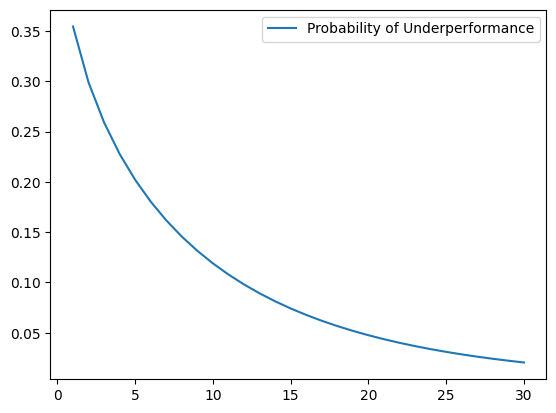

In [12]:
def prob(mu, sigma, h):
    return norm.cdf(np.sqrt(h)*mu/sigma)

mu, sigma = res_stats['1965 - 1999'].loc[('logs', 'excess_returns')]

print(f'SPX underperforming RF in the next 15 years after 1999: {prob(mu = -mu, sigma = sigma, h = 15):,.2%}')

print(f'SPX underperforming RF in the next 30 years after 1999: {prob(mu = -mu, sigma = sigma, h = 30):,.2%}')

h = np.arange(30) + 1
probs = pd.DataFrame([prob(-mu, sigma, x) for x in h], columns=['Probability of Underperformance'], index = h)
probs.plot();

### 4.3

Use the sample 1965-2024 to reconsider the 30-year probability. As of the end of 2024, calculate the probability of the stock return underperforming the risk-free rate over the next 30 years. That is, $R_{t, t+h}^M$ underperforming $R_{t, t+h}^f$ for $0<h \leq 30$.

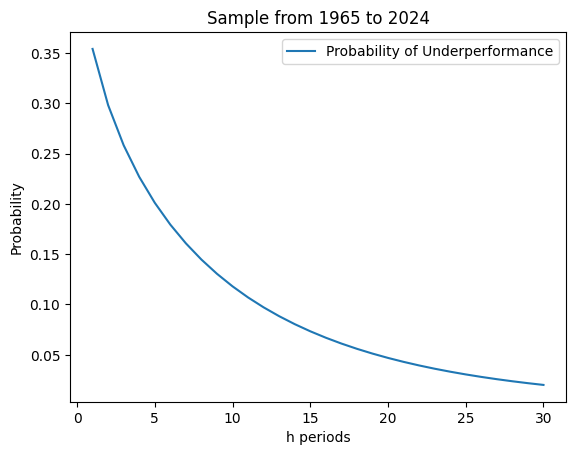

In [13]:
mu = np.log(1+rets.loc['1965':'2024']).mean() * 12
sigma = np.log(1+rets.loc['1965':'2024']).std() * np.sqrt(12)
h = np.arange(30)+1

probs = pd.DataFrame([prob(-mu, sigma, x) for x in h], columns=['Probability of Underperformance'], index = h)
probs.plot(title = 'Sample from 1965 to 2024', ylabel = 'Probability', xlabel = 'h periods')
plt.show()

### 4.4

Let's consider how things turned out relative to Barnstable's 1999 expectations. <br>
What was the probability (based on the 1999 estimate of $\mu$,) that the 25-year market return, $R_{t, t+25}^M$, would be smaller than that realized in 2000-2024? Note that we are asking about the market return, not the excess market return. Continue using the 1965-1999 sample standard deviation for $\sigma$.

In [14]:
# Because we are asked for market return, we are using SPX instead of Excess Return. We will use the log.
mu = res_stats[('1965 - 1999', 'mean')].loc[('logs', 'SPX')] - res_stats[('2000 - 2024', 'mean')].loc[('logs', 'SPX')]
sigma = res_stats[('1965 - 1999', 'vol')].loc[('logs', 'SPX')]

print(f"Probability of underperformance in 2000-2024: {prob(-mu, sigma, 25):,.2%}")

Probability of underperformance in 2000-2024: 7.85%
